## Harmony integration for Colorectal Cancer Samples


In [2]:
import scanpy as sc
import scanpy.external as sce


In [3]:
root_folder = '../../data/'

dataset = 'ColorectalCancer'
count_file = 'filtered_feature_bc_matrix.h5'

usecases=['Sample_SN123_A595688_Rep1', 'Sample_SN048_A121573_Rep2','Sample_SN048_A121573_Rep1']

In [ ]:
adata_all = []

# load adata normalised and log transformed
for usecase in usecases:
    adata= sc.read_visium(f"{root_folder}/{dataset}/{usecase}", count_file=count_file, load_images=True)
    # make var_names_make_unique
    adata.var_names_make_unique()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    adata_all.append(adata)

In [10]:
# concatenate all samples
adata_concat = sc.concat(
    adata_all,
    label="library_id",
    uns_merge="unique",
    keys=[
        k
        for d in [adata.uns["spatial"] for adata in adata_all]
        for k, v in d.items()
    ],
    index_unique="-",
    join='outer',
)

In [12]:
adata_concat

AnnData object with n_obs × n_vars = 7052 × 22028
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'library_id'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [ ]:
# apply PCA, neighbours and UMAP
print('Calculating PCA')
sc.pp.pca(adata_concat)
print('Calculating neighbours')
sc.pp.neighbors(adata_concat)
print('Calculating UMAP')
sc.tl.umap(adata_concat)
print('DONE')


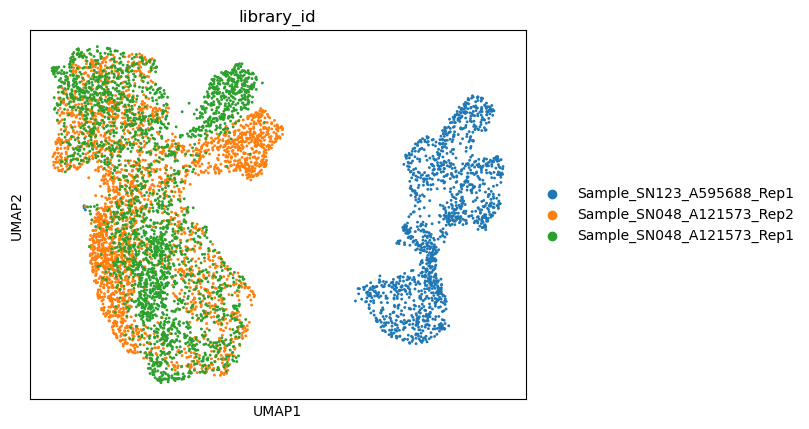

In [15]:
# show UMAP per sample
sc.pl.umap(adata_concat, color='library_id')

In [16]:
# perform Harmony integration
print('Running Harmony')
sce.pp.harmony_integrate(adata_concat, 'library_id')
print('DONE')

2025-06-06 14:22:55,895 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony


2025-06-06 14:22:56,641 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-06 14:22:56,672 - harmonypy - INFO - Iteration 1 of 10
2025-06-06 14:22:58,119 - harmonypy - INFO - Iteration 2 of 10
2025-06-06 14:22:59,457 - harmonypy - INFO - Iteration 3 of 10
2025-06-06 14:23:00,754 - harmonypy - INFO - Iteration 4 of 10
2025-06-06 14:23:02,302 - harmonypy - INFO - Iteration 5 of 10
2025-06-06 14:23:03,636 - harmonypy - INFO - Iteration 6 of 10
2025-06-06 14:23:05,132 - harmonypy - INFO - Iteration 7 of 10
2025-06-06 14:23:06,599 - harmonypy - INFO - Iteration 8 of 10
2025-06-06 14:23:08,274 - harmonypy - INFO - Iteration 9 of 10
2025-06-06 14:23:09,862 - harmonypy - INFO - Iteration 10 of 10
2025-06-06 14:23:11,129 - harmonypy - INFO - Stopped before convergence


DONE


In [17]:
# perform UMAP on integrated data
print('Calculating Neighbours')
sc.pp.neighbors(adata_concat, use_rep='X_pca_harmony')
print('Calculating UMAP')
sc.tl.umap(adata_concat)




Calculating Neighbours
Calculating UMAP


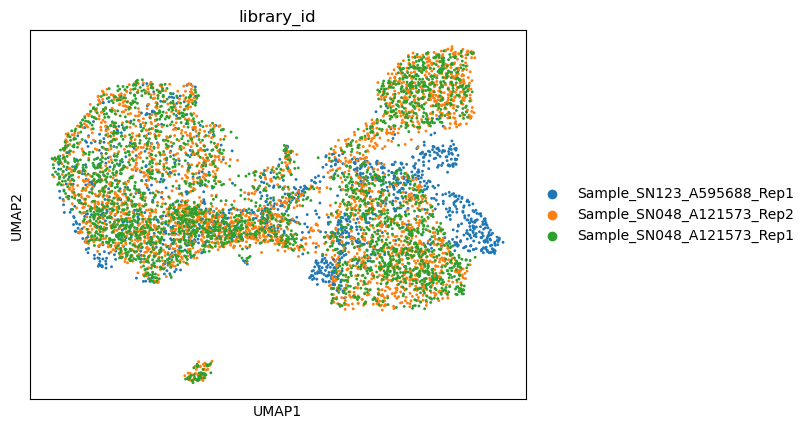

In [18]:
# show UMAP per sample
sc.pl.umap(adata_concat, color='library_id')

In [19]:
# perform clustering
print('Performing clustering')
for resolution in [1.0, 0.8, 0.5, 0.3]:
    print(f'Clustering with resolution {resolution}')
    sc.tl.leiden(adata_concat, resolution=resolution, key_added=f'leiden_{resolution}', n_iterations=2)
    print(f'Done')

Performing clustering
Clustering with resolution 1.0


<ipython-input-19-6d52a3ebafb8>:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_concat, resolution=resolution, key_added=f'leiden_{resolution}', n_iterations=2)


Done
Clustering with resolution 0.8
Done
Clustering with resolution 0.5
Done
Clustering with resolution 0.3
Done


In [ ]:
# show cluster annotation on top of image
cls_labels = [f'leiden_{resolution}' for resolution in [1.0, 0.8, 0.5, 0.3]]
for sample in usecases:
    adata = adata_concat[adata_concat.obs['library_id'] == sample]
    sc.pl.spatial(adata, library_id=sample, color=cls_labels)

In [ ]:
sc.pp.highly_variable_genes(adata_concat, n_top_genes=1000)
sc.pp.pca(adata_concat, n_comps=50, use_highly_variable=True, svd_solver='arpack')


In [ ]:
# write each of the samples to a separate file in their own folder "{root_folder}/{dataset}/{usecase}" adata_harmony.h5ad
for usecase in usecases:    
    adata = adata_concat[adata_concat.obs['library_id'] == usecase]
    # remove -Sample_SN048_A121573_Rep1 from index of obs
    adata.obs.index = adata.obs.index.str.replace(f'-{usecase}', '')
    adata.write(f"{root_folder}/{dataset}/{usecase}/adata_harmony_1k_highly_variable.h5ad")